In [1]:
from helpers import get_client, get_data
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import matplotlib.lines as mlines
from matplotlib.patches import Patch

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
es = get_client()  
upload_latency_df = get_data("aggregated-curr-ulping-*", es)
download_latency_df = get_data("aggregated-curr-dlping-*", es)
upload_speed_df = get_data("aggregated-curr-httppostmt-*", es)
download_speed_df = get_data("aggregated-curr-httpgetmt-*", es)

Connected to Elasticsearch.


In [3]:
sns.set_theme(style="whitegrid")

tech_groups = ['Overall', 'DSL', 'Cable', 'Fiber']

for df in [upload_latency_df, upload_speed_df, download_latency_df, download_speed_df]:
    df['date'] = pd.to_datetime(df['date'])
    df.dropna(inplace=True)

latency_color = sns.color_palette("tab10")[0]
speed_color = sns.color_palette("tab10")[1]

In [ ]:
def create_subplots(latency_df, speed_df, title_prefix, latency_ylim, speed_ylim):
    fig, axs = plt.subplots(2, 2, figsize=(23, 12))
    axs = axs.flatten()

    for i, tech in enumerate(tech_groups):
        if tech == 'Overall':
            lat = latency_df.copy()
            speed = speed_df.copy()
        else:
            lat = latency_df[latency_df['operator_technology'] == tech].copy()
            speed = speed_df[speed_df['operator_technology'] == tech].copy()

        # Compute latency median and IQR
        lat_month = lat.set_index('date').resample('M')['rtt_avg'].median().reset_index()
        lat_month_25 = lat.set_index('date').resample('M')['rtt_avg'].quantile(0.25).reset_index()['rtt_avg']
        lat_month_75 = lat.set_index('date').resample('M')['rtt_avg'].quantile(0.75).reset_index()['rtt_avg']
        
        # Compute speed median and IQR
        speed_month = speed.set_index('date').resample('M')['throughput'].median().reset_index()
        speed_month_25 = speed.set_index('date').resample('M')['throughput'].quantile(0.25).reset_index()['throughput']
        speed_month_75 = speed.set_index('date').resample('M')['throughput'].quantile(0.75).reset_index()['throughput']

        merged = pd.merge(lat_month, speed_month, on='date', how='inner').sort_values('date')
        merged['lat_25'] = lat_month_25.interpolate()
        merged['lat_75'] = lat_month_75.interpolate()
        merged['speed_25'] = speed_month_25.interpolate()
        merged['speed_75'] = speed_month_75.interpolate()
        merged['rtt_avg'] = merged['rtt_avg'].interpolate()
        merged['throughput'] = merged['throughput'].interpolate()

        ax = axs[i]
        ax2 = ax.twinx()

        # Plot latency
        ax.plot(merged['date'], merged['rtt_avg'], label='Latency Median', color=latency_color)
        ax.fill_between(merged['date'], merged['lat_25'], merged['lat_75'], color=latency_color, alpha=0.3)
        # Plot speed
        ax2.plot(merged['date'], merged['throughput'], label='Speed Median', color=speed_color)
        ax2.fill_between(merged['date'], merged['speed_25'], merged['speed_75'], color=speed_color, alpha=0.3)

        ax.set_title(f"{tech}")
        ax.set_xlabel("Year")
        ax.set_ylabel("Latency (ms)", color=latency_color)
        ax2.set_ylabel("Speed (throughput)", color=speed_color)

        ax.set_ylim(*latency_ylim)
        ax2.set_ylim(*speed_ylim)

        ax.xaxis.set_major_locator(mdates.YearLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        ax.tick_params(axis='x', rotation=45)

        ax.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5)
        ax2.grid(False)

    # legend and title as before
    lat_line  = mlines.Line2D([], [], color=latency_color, label='Latency Median')
    lat_patch = Patch(color=latency_color, alpha=0.3, label='Latency IQR')
    speed_line  = mlines.Line2D([], [], color=speed_color, label='Speed Median')
    speed_patch = Patch(color=speed_color, alpha=0.3, label='Speed IQR')

    fig.legend(
        handles=[lat_line, lat_patch, speed_line, speed_patch],
        loc='upper right', bbox_to_anchor=(0.98, 1),
        fontsize='large', ncols=4
    )
    fig.suptitle(title_prefix, fontsize='x-large')
    plt.tight_layout(rect=[0, 0, 1, 0.97], h_pad=4, w_pad=4)
    plt.savefig(f"./plots/latency_vs_speed/{title_prefix}.png", dpi=600)
    plt.show()


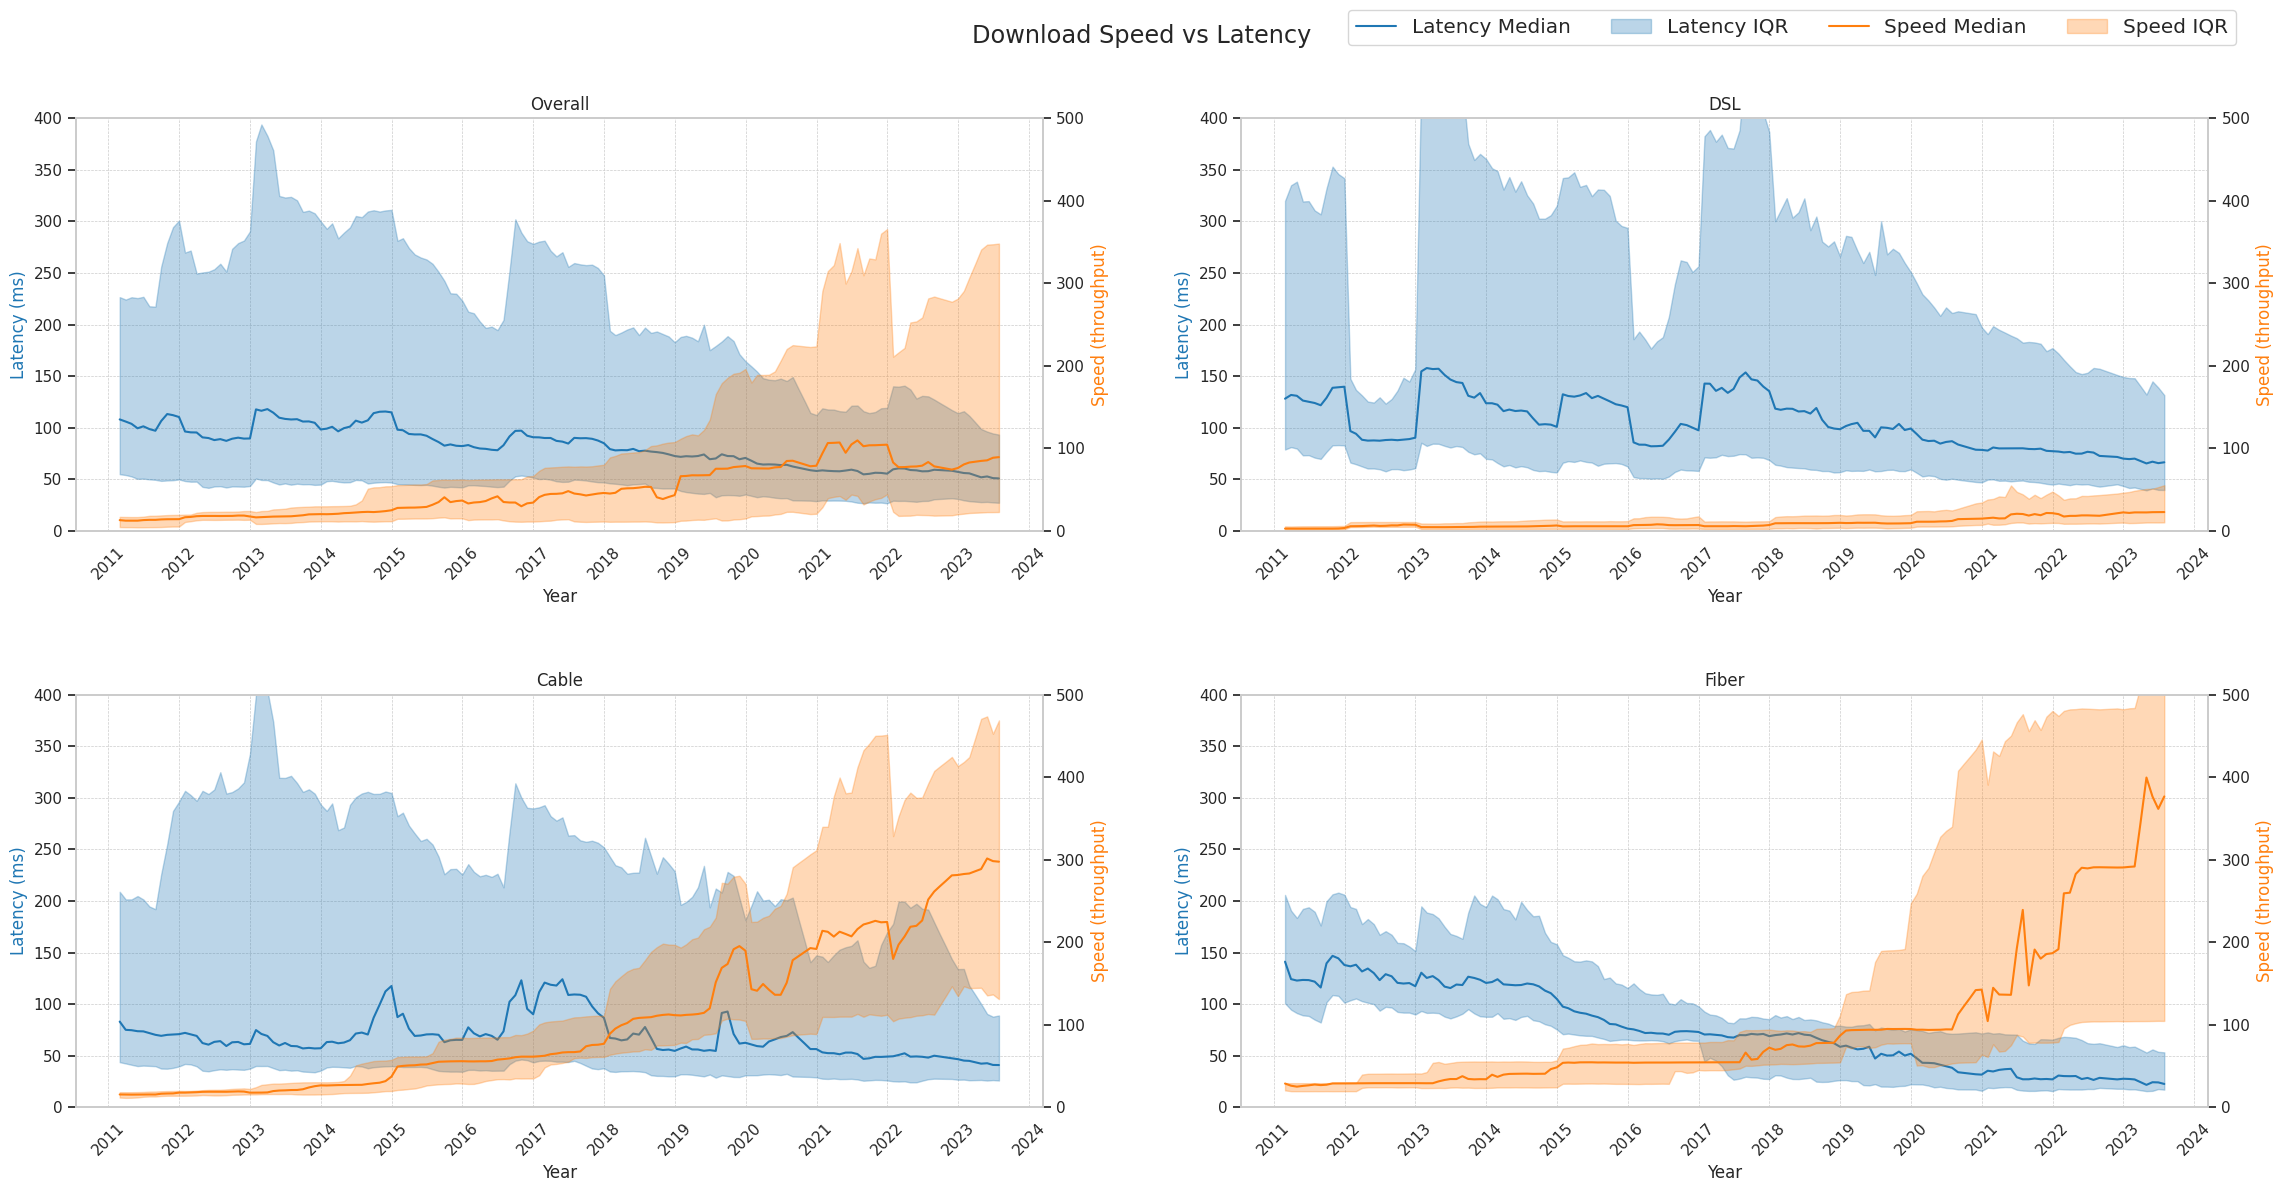

In [ ]:
# Download plots: latency 0–400 ms, speed 0–500 units
create_subplots(
    download_latency_df,
    download_speed_df,
    "Download Speed vs Latency",
    latency_ylim=(0, 400),
    speed_ylim=(0, 500)
)

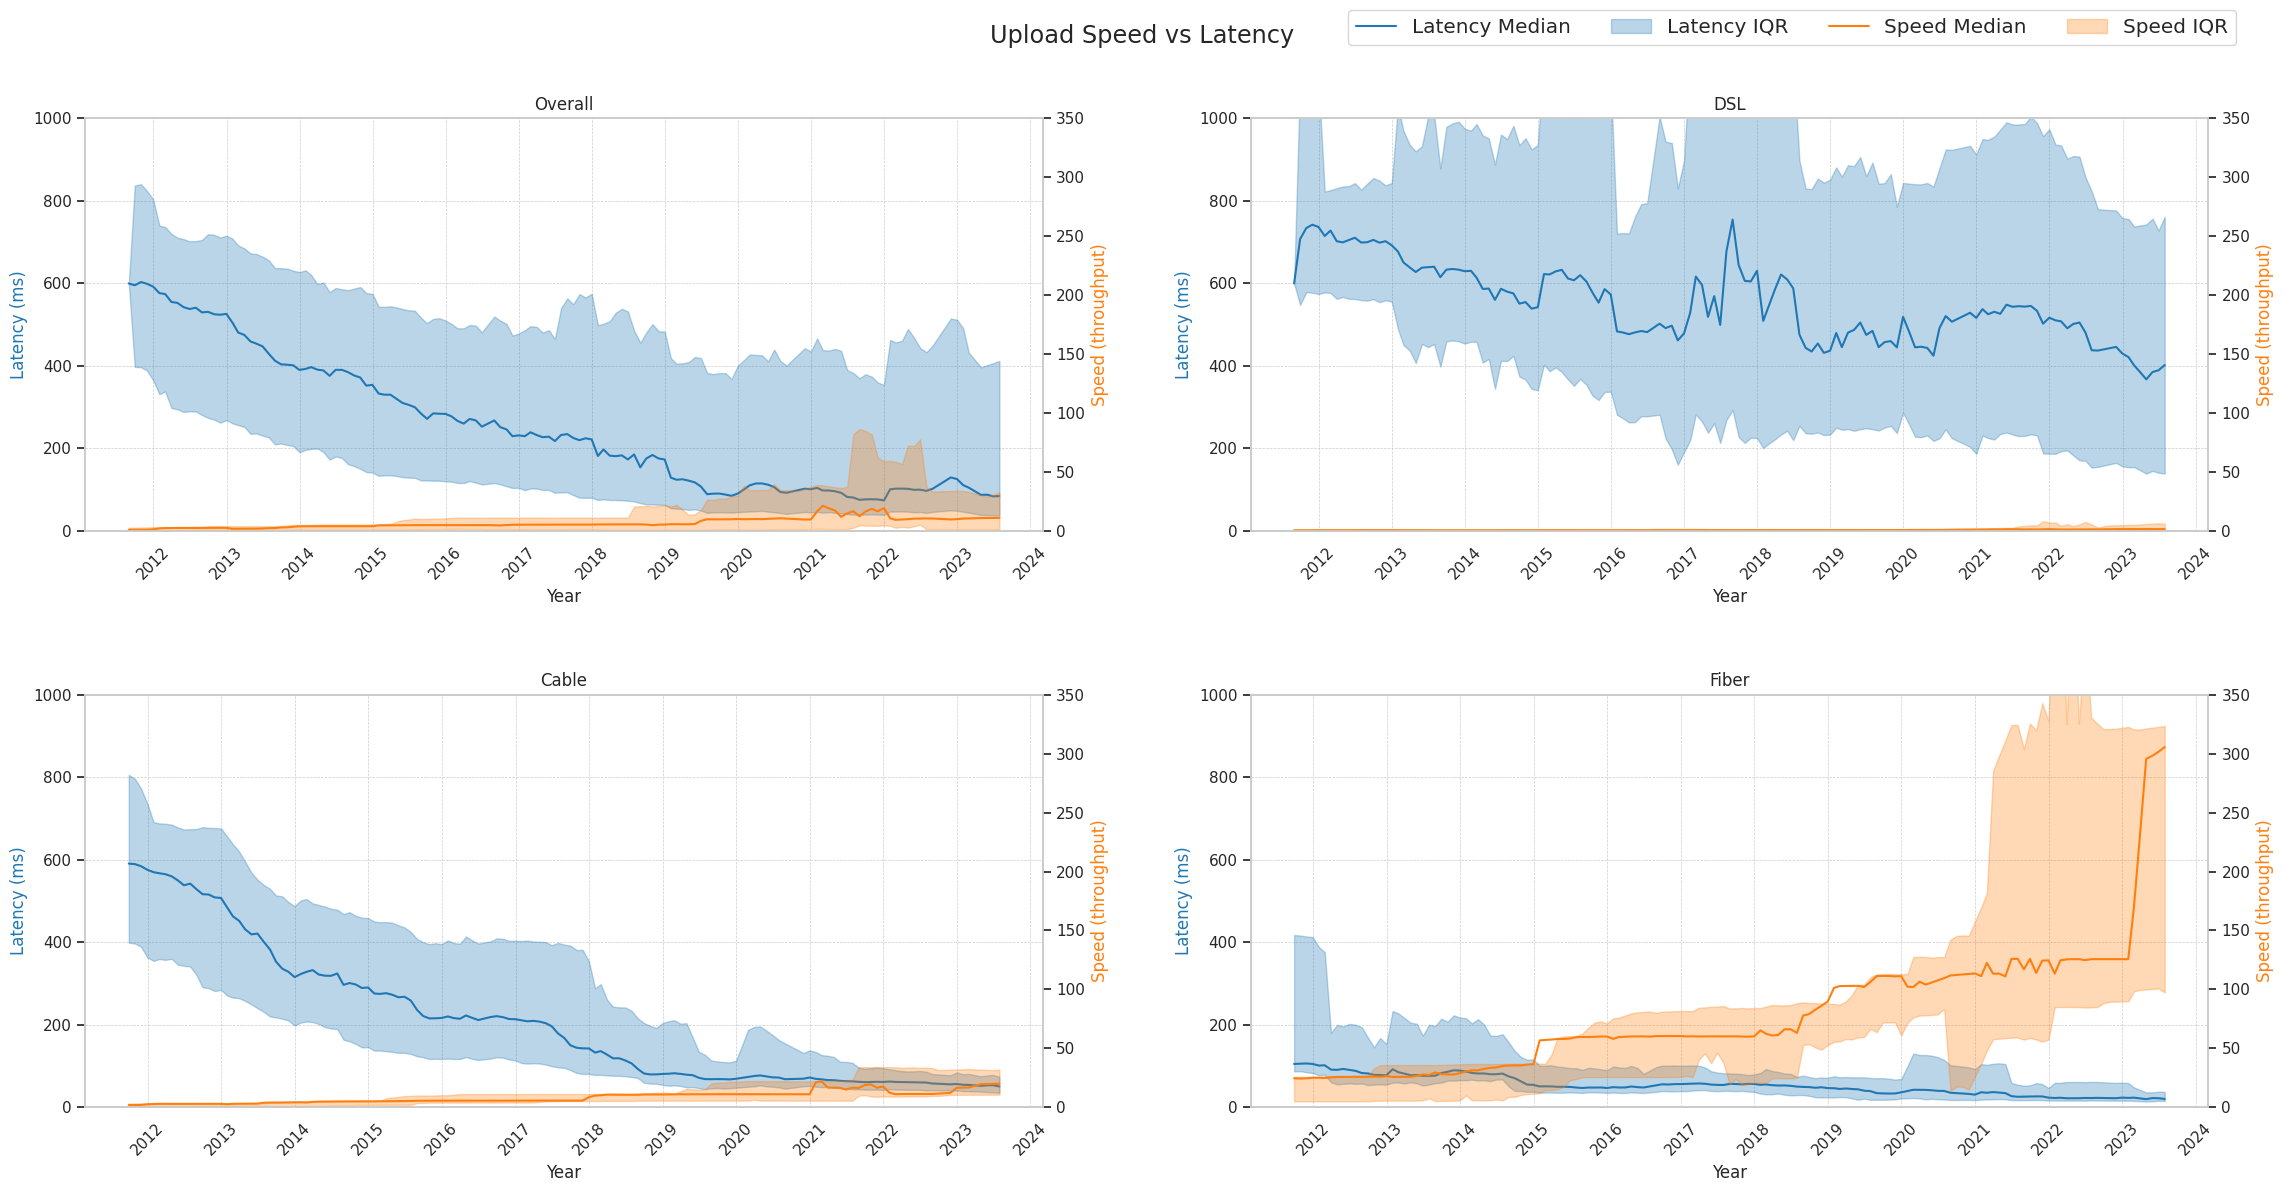

In [ ]:
# Upload plots: latency 0–1000 ms, speed 0–350 units
create_subplots(
    upload_latency_df,
    upload_speed_df,
    "Upload Speed vs Latency",
    latency_ylim=(0, 1000),
    speed_ylim=(0, 350)
)
